## Load Data

In [ ]:
!git clone https://github.com/gveres/donateacry-corpus.git

Cloning into 'donateacry-corpus'...
remote: Enumerating objects: 1616, done.
remote: Total 1616 (delta 0), reused 0 (delta 0), pack-reused 1616 (from 1)
Receiving objects: 100% (1616/1616), 67.06 MiB | 11.64 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Updating files: 100% (1587/1587), done.


In [ ]:
# File and system operations
import os
import random

# Audio processing
import librosa
import librosa.display
import soundfile as sf

# Numerical and data handling
import numpy as np
import pandas as pd

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Deep learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.utils import to_categorical

# Visualization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize



np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
base_path = '/content/donateacry-corpus/donateacry_corpus_cleaned_and_updated_data'

for label in os.listdir(base_path):
    path = os.path.join(base_path, label)
    if os.path.isdir(path):
        num_files = len(os.listdir(path))
        print(f"{label}: {num_files} files")
    else:
        print(f"{label} is a file, not a directory. Deleting...")
        os.remove(path)

hungry: 382 files
discomfort: 27 files
tired: 24 files
belly_pain: 16 files
README.md is a file, not a directory. Deleting...
burping: 8 files


"Terlihat bahwa ada imbalanced yang cukup kuat. Label hungry mendominasi sendiri. Maka kita perlu lakukan augmentasi data pada 4 label lainnya."

## Data Augmentation

In [ ]:
SAMPLE_RATE = 16000
def load_audio(file_path, sr=SAMPLE_RATE):
    """Loads an audio file."""
    audio, sr = librosa.load(file_path, sr=sr)
    return audio, sr

def save_audio(audio, output_file_path, sr = SAMPLE_RATE):
    """Saves an audio file."""
    sf.write(output_file_path, audio, sr)

def time_shift(audio,sr, shift_range=(-500, 500)):
    """Shifts the audio signal in time."""
    shift = np.random.randint(shift_range[0], shift_range[1])
    return np.roll(audio, shift)

def time_stretch(audio,sr, rate_range=(0.8, 1.2)):
    """Stretches or compresses the audio signal without changing pitch."""
    rate = np.random.uniform(rate_range[0], rate_range[1])
    return librosa.effects.time_stretch(audio, rate=rate)

def pitch_shift(audio, sr=SAMPLE_RATE, semitones=4):
    """Changes the pitch of the audio signal."""
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=semitones)

def add_white_noise(audio,sr, mean=0, variance=0.000025, power=0.005):
    """Adds white noise to the audio signal."""
    noise = np.random.normal(mean, np.sqrt(variance), len(audio))
    audio_amplitude = np.max(np.abs(audio))
    scaled_noise = noise * audio_amplitude * power
    return audio + scaled_noise

def audio_slice(audio, sr = SAMPLE_RATE, duration=1):
    slice_length = int(duration * sr)
    if len(audio) <= slice_length:
        return librosa.util.fix_length(audio, size=slice_length)
    start = random.randint(0, len(audio) - slice_length)
    return audio[start:start + slice_length]

In [ ]:
AUGMENTATION_FUNCTIONS = [
    (time_shift, "shift"),
    (time_stretch, "stretch"),
    (pitch_shift, "pitch"),
    (add_white_noise, "noise"),
    (audio_slice, "slice")
]

In [ ]:
def augment_data(data_path, output_dir, p):
    audio, sr = load_audio(data_path)
    base_filename = os.path.splitext(os.path.basename(data_path))[0]

    for i in range(p):
        aug_func, aug_name = random.choice(AUGMENTATION_FUNCTIONS)
        augmented_audio = aug_func(audio, sr)

        output_filename = f"{base_filename}_{aug_name}_{i+1}.wav"
        output_file_path = os.path.join(output_dir, output_filename)

        save_audio(augmented_audio, sr=16000, output_file_path=output_file_path)

In [ ]:
for label in os.listdir(base_path):
  path = os.path.join(base_path, label)
  if os.path.isdir(path):
    label_path = path
    if label!='hungry':
      for file in os.listdir(path):
        file_path=os.path.join(label_path, file)
        augment_data(file_path, label_path, 17)

In [ ]:
base_path = '/content/donateacry-corpus/donateacry_corpus_cleaned_and_updated_data'

for label in os.listdir(base_path):
    path = os.path.join(base_path, label)
    if os.path.isdir(path):
        num_files = len(os.listdir(path))
        print(f"{label}: {num_files} files")
    else:
        print(f"{label} is a file, not a directory")

hungry: 382 files
discomfort: 486 files
tired: 432 files
belly_pain: 288 files
burping: 144 files


## Data Resizing

In [ ]:
def trim_or_pad(audio, sr, target_duration=6.0):
    target_length = int(sr * target_duration)
    if len(audio) > target_length:
        start = (len(audio) - target_length) // 2
        audio = audio[start:start + target_length]
    elif len(audio) < target_length:
        pad_length = target_length - len(audio)
        pad_left = pad_length // 2
        pad_right = pad_length - pad_left
        audio = np.pad(audio, (pad_left, pad_right), mode='constant')
    return audio

In [ ]:
for label in os.listdir(base_path):
    path = os.path.join(base_path, label)
    if os.path.isdir(path):
        for file in os.listdir(path):
            file_path = os.path.join(path, file)
            audio, sr = load_audio(file_path)
            processed_audio = trim_or_pad(audio, sr=16000, target_duration=6.0)
            save_audio(processed_audio, sr=16000, output_file_path=file_path)

## Feature Extraction

In [ ]:
n_mfcc = 40
n_fft = 1024
hop_length = 10*16
win_length = 25*16
window = 'hann'
n_chroma=12
n_mels=128
n_bands=7
fmin=100
bins_per_ocatve=12

In [ ]:
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=16000)
        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13,n_fft=n_fft,hop_length=hop_length,win_length=win_length,window=window).T,axis=0)
        mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr,n_fft=n_fft, hop_length=hop_length, win_length=win_length, window='hann',n_mels=n_mels).T,axis=0)
        stft = np.abs(librosa.stft(y))
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, y=y, sr=sr).T,axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, y=y, sr=sr,n_fft=n_fft,
                                                      hop_length=hop_length, win_length=win_length,
                                                      n_bands=n_bands, fmin=fmin).T,axis=0)
        tonnetz =np.mean(librosa.feature.tonnetz(y=y, sr=sr).T,axis=0)
        features = np.concatenate((mfcc, chroma, mel, contrast, tonnetz))
        # print(shape(features))
        return features
    except:
        print("Error: Exception occurred in feature extraction")
        return None

path = '/content/donateacry-corpus/donateacry_corpus_cleaned_and_updated_data'
features = []
labels = []

for label in os.listdir(path):
    label_path = os.path.join(path, label)
    if os.path.isdir(label_path):
        print(f"{label} data is loading.....")
        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            feature = extract_features(file_path)
            if feature is not None:
                features.append(feature)
                labels.append(label)
        print(f"{label} data loaded....")

hungry data is loading.....
hungry data loaded....
discomfort data is loading.....
discomfort data loaded....
tired data is loading.....
tired data loaded....
belly_pain data is loading.....
belly_pain data loaded....
burping data is loading.....
burping data loaded....


## Modelling

In [ ]:
features = np.array(features)
labels = np.array(labels)

le = LabelEncoder()
labels = le.fit_transform(labels)
labels = to_categorical(labels, num_classes=5)

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.15, random_state=42, stratify=labels)

In [ ]:
input_shape=(X_train.shape[1],)
num_classes=5

In [ ]:
model_ANN = Sequential([
    InputLayer(shape=input_shape),

    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

model_ANN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_ANN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │       172,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 877,573 (3.35 MB)

 Trainable params: 873,605 (3.33 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [ ]:
history_ANN=model_ANN.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.1748 - loss: 2.7076 - val_accuracy: 0.0608 - val_loss: 6.4913
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2515 - loss: 2.2010 - val_accuracy: 0.2027 - val_loss: 2.6637
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2842 - loss: 2.0814 - val_accuracy: 0.2905 - val_loss: 1.6436
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3244 - loss: 1.8564 - val_accuracy: 0.3108 - val_loss: 1.6253
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3201 - loss: 1.8251 - val_accuracy: 0.3514 - val_loss: 1.4806
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3359 - loss: 1.6905 - val_accuracy: 0.4595 - val_loss: 1.2614
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3529 - loss: 1.6345 - val_accuracy: 0.4932 - val_loss: 1.2345
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3688 - loss: 1.5505 - val_accuracy: 0.5473 

In [ ]:
y_pred=np.argmax(model_ANN.predict(X_test), axis=1)
y_true=np.argmax(y_test, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


In [ ]:
print(classification_report(y_true, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

  belly_pain       0.88      0.81      0.84        43
     burping       0.79      1.00      0.88        22
  discomfort       0.83      0.89      0.86        73
      hungry       0.96      0.75      0.84        57
       tired       0.75      0.80      0.78        65

    accuracy                           0.83       260
   macro avg       0.84      0.85      0.84       260
weighted avg       0.84      0.83      0.83       260



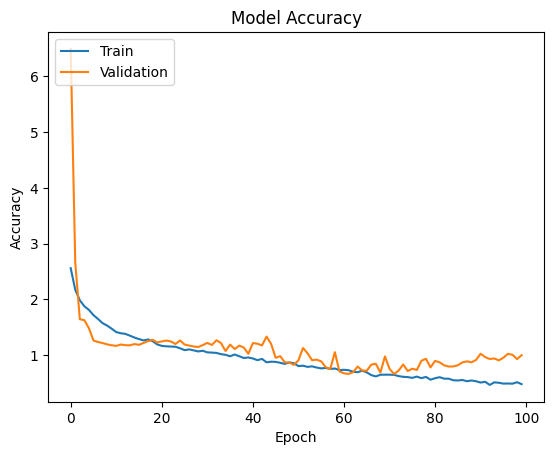

In [ ]:
plt.plot(history_ANN.history['loss'])
plt.plot(history_ANN.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

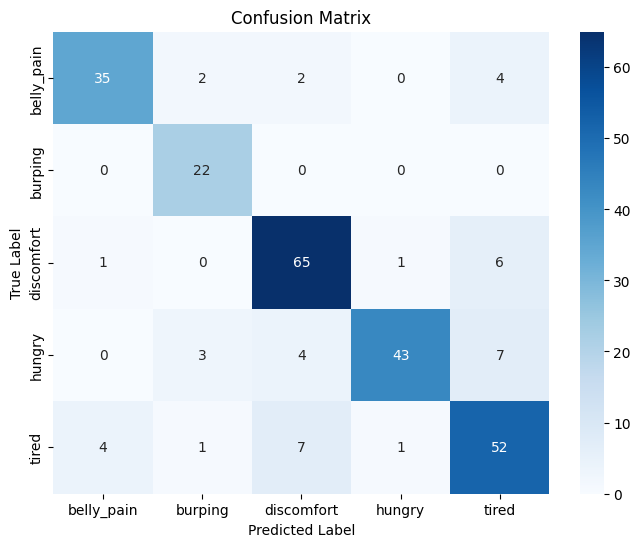

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


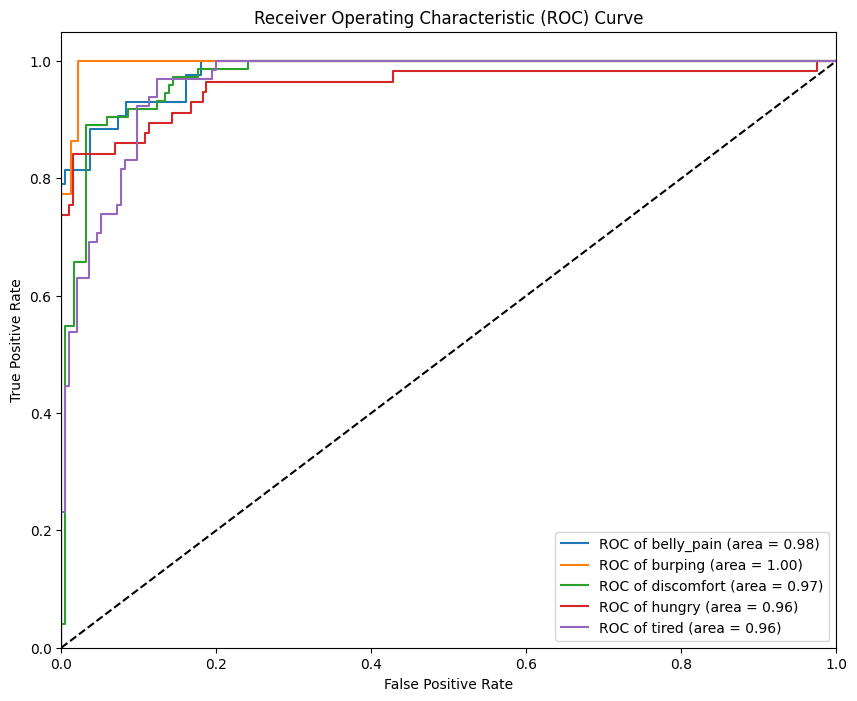

In [ ]:
y_test_bin = label_binarize(y_true, classes=np.arange(num_classes))
y_pred_prob = model_ANN.predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC of {0} (area = {1:0.2f})'
                                   ''.format(le.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
